In [3]:
# import main data analysis libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# note we use scipy for generating a uniform distribution in the model optimization step
from scipy.stats import uniform

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [4]:
# we load the dataset and save it as the variable data
data = load_breast_cancer()

# if we want to know what sort of detail is provided with this dataset, we can call .keys()
data.keys()

# the info at the .DESCR key will tell us more 
print (data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
#### Analyze the Data
X = pd.DataFrame(data.data, columns = data.feature_names)

# we can then look at the top of the dataframe to see the sort of values it contains
X.describe(include = 'all')

# we can now look at our target variable 
y = data.target

# we can see that it is a list of 0s and 1s, with 1s matching to the Benign class y

In [6]:
# we can analyse the data in more detail by understanding how the features and target variables interact
# we can do this by grouping the features and the target into the same dataframe
# note we create a copy of the data here so that any changes don't impact the original data

full_dataset = X.copy()
full_dataset['target'] = y.copy()

# let's take a look at the first few lines of the dataset
full_dataset.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [7]:
# lets see how balanced the classes are (and if that matches to our expectation)
full_dataset['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [ ]:
# let's evaluate visually how well our classes are differentiable on the pairplots
# can see two classes being present on a two variables charts?
# the pairplot function is an excellent way of seeing how variables inter-relate, but 30 feature can make studying each combination difficult!
sns.pairplot(full_dataset, hue = 'target')

* We can clearly see the presence of two clouds with different colors, representing our target classes. 
* Of course, they are still mixed to some extent, but if we were to visualise the variables in multi-dimentional space they would become more separable.
* Now let's check the Pearson's correlation between pairs of our features and also between the features and our target.


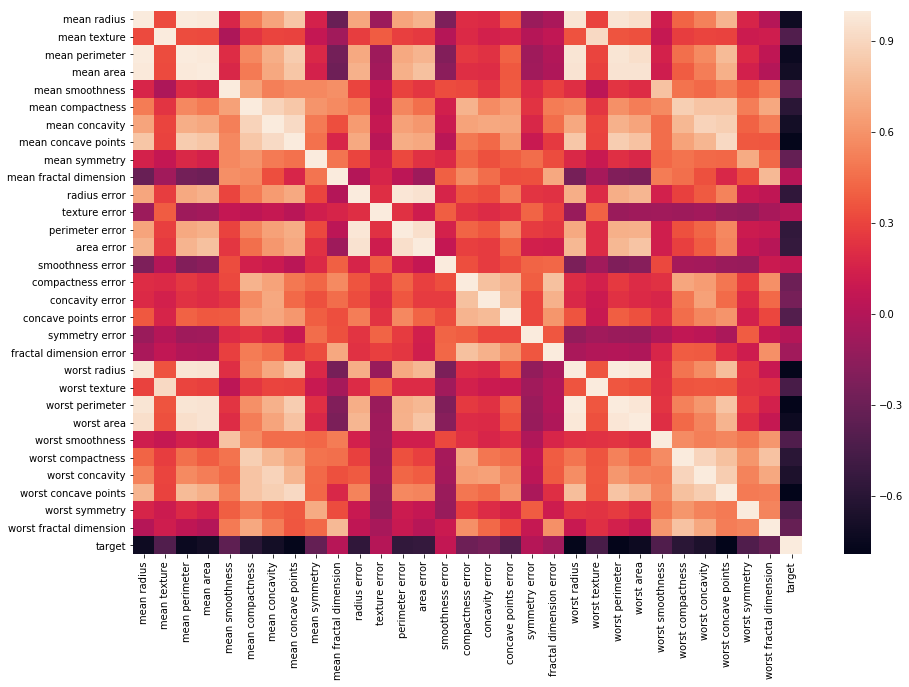

In [ ]:
# we can again use seaborn to easily create a visually interesting chart 
plt.figure(figsize = (15, 10))

# we can add the annot=True parameter to the sns.heatmap arguments if we want to show the correlation values 
sns.heatmap(full_dataset.corr(method='pearson'))

* Dark red colours are positilvey correlated with the corresponding feature, dark blue features are negatively correlated.
* We can see that some values are negatively correlated with our target variable.
* This information could help us with feature engineering.


**Split data**
* In order to train our model and see how well it performs, we need to split our data into training and testing sets.
* We can then train our model on the training set, and test how well it has generalised to the data on the test set.
* There are a number of options for how we can split the data, and for what proportion of our original data we set aside for the test set.


In [8]:
# Because our classes are not absolutely equal in number, we can apply stratification to the split 
# and be sure that the ratio of the classes in both train and test will be the same 
# you can learn about the other parameters by looking at the documentation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle=True)

In [9]:
# as with Day 1, we can get shape of test and training sets
print('Training Set:')
print('Number of datapoints: ', X_train.shape[0])
print('Number of features: ', X_train.shape[1])
print('\n')
print('Test Set:')
print('Number of datapoints: ', X_test.shape[0])
print('Number of features: ', X_test.shape[1])

Training Set:
Number of datapoints:  455
Number of features:  30


Test Set:
Number of datapoints:  114
Number of features:  30


In [10]:
# and we can verify the stratifications using np.bincount
print('Labels counts in y:', np.bincount(y))
print('Percentage of class zeroes in class_y',np.round(np.bincount(y)[0]/len(y)*100))

print("\n")
print('Labels counts in y_train:', np.bincount(y_train))
print('Percentage of class zeroes in y_train',np.round(np.bincount(y_train)[0]/len(y_train)*100))

print("\n")
print('Labels counts in y_test:', np.bincount(y_test))
print('Percentage of class zeroes in y_test',np.round(np.bincount(y_test)[0]/len(y_test)*100))

Labels counts in y: [212 357]
Percentage of class zeroes in class_y 37.0


Labels counts in y_train: [170 285]
Percentage of class zeroes in y_train 37.0


Labels counts in y_test: [42 72]
Percentage of class zeroes in y_test 37.0


### Choose a Baseline algorithm
* Building a model in `sklearn` involves:
* we can create a baseline model to benchmark our other estimators against
* this can be a simple estimator or we can use a dummy estimator to make predictions in a random manner 


In [11]:
# this creates our dummy classifier, and the value we pass in to the strategy parameter determin
dummy = DummyClassifier(strategy='uniform', random_state=1)

In [12]:
# Train and Test the Model
# "Train" model
dummy.fit(X_train, y_train)

# from this, we can generate a set of predictions on our unseen features, X_test
dummy_predictions = dummy.predict(X_test)

### Choose an evaluation metric
* We then need to compare these predictions with the actual result and measure them in some way. This is where the selection of evaluation metric is important. 
* Classification metrics include:
  * `accuracy`: this assess how often the model selects the best class. This can be more useful when there are balanced classes (i.e. there are a similar number of instances of each class we are trying to predict). 
    * There are some limits to this metric. For example, if we think about something like credit card fraud, where the instances of fraudulent transactions might be 0.5%, then a model that *always* predicts that a transaction is not fraudulent will be 99.5% accurate! So we often need metrics that can tell us how a model performs in more detail. 
  * `f1 score`: 
  * `roc_auc`: 
  * `recall`: 
  * We recommend you research these metrics to improve your understanding of how they work. Try to look up an explanation or two (for example on wikipedia and scikit-learn documentation) .

In [13]:
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)

    print ("Accuracy", accuracy)
    print ('F1 score: ', f1)
    print ('ROC_AUC: ' , auc)

# we can call the function on the actual results versus the predictions
# we will see that the metrics are what we'd expect from a random model 
evaluate(y_test, dummy_predictions)

Accuracy 0.5087719298245614
F1 score:  0.5882352941176471
ROC_AUC:  0.4920634920634921


In [15]:
# Test Alternative Models

## here we fit a new estimator and use cross_val_score to get a score based on a defined metric 

# instantiate logistic regression classifier
log_clf = LogisticRegression()

In [16]:
# we pass our estimator and data to the method. we also specify the number of folds (default is 3)
# the default scoring method is the one associated with the estimator we pass in
# we can use the scoring parameter to pass in different scoring methods. Here we use f1.  
cross_val_score(log_clf, X, y, cv=5, scoring="f1")

array([0.95302013, 0.95104895, 0.96598639, 0.95833333, 0.97142857])

In [18]:
# we can see that this returns a score for all the five folds of the cross_validation
# if we want to return a mean, we can store as a variable and calculate the mean, or do it directly on the function
# this time we will use accuracy
cross_val_score(log_clf, X, y, cv=5, scoring="accuracy").mean()

0.9490607048594939

In [19]:
# lets do this again with a different model
rnd_clf = RandomForestClassifier()

In [20]:
# and pass that in 
cross_val_score(rnd_clf, X, y, cv=5, scoring="accuracy").mean

<function ndarray.mean>


**Ensemble models** 

* Let's take this opportunity to explore ensemble methods.
* The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone. 
* There are several different approaches to achieve this, including **majority voting** ensemble methods, which we select the class label that has been predicted by the majority of classifiers.
* The ensemble can be built from different classification algorithms, such as decision trees, support vector machines, logistic regression classifiers, and so on. Alternatively, we can also use the same base classification algorithm, fitting different subsets of the training set. 
* Indeed, Majority voting will work best if the classifiers used are different from each other and/or trained on different datasets (or subsets of the same data) in order for their errors to be uncorrelated.

In [21]:
# lets instantiate an additional model to make an ensemble of three models
dt_clf = DecisionTreeClassifier()

In [22]:
# and an ensemble of them
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('dc', dt_clf)],                              
                              # here we select soft voting, which returns the argmax of the sum of predicted probabilities
                              voting='soft')

In [23]:
# here we can cycle through the individual estimators 
# for clf in (log_clf, rnd_clf, svm_clf, voting_clf):

for clf in (log_clf, rnd_clf, dt_clf, voting_clf):
    
    # fit them to the training data 
    clf.fit(X_train, y_train)
    
    # get a prediction
    y_pred = clf.predict(X_test)
    
    # and print the prediction 
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9912280701754386
RandomForestClassifier 0.9824561403508771
DecisionTreeClassifier 0.9736842105263158
VotingClassifier 0.9912280701754386


* We can see that `voting classifier` in this the case does have a slight edge on the other models (note that this could vary depending on how the data is split at training time).
* This is an interesting approach and one to consider when you are developing your models.

### Step 9: Choose the best model and optimise its parameters
* We can see that we have improved our model as we have added features and trained new models.
* At the point that we feel comfortable with a good model, we can start to tune the parameters of the model.
* There are a number of ways to do this. We can apply `GridSearchCV` to identify the best hyperparameters for our models.
* There are other methods available to use that don't take the brute force approach of `GridSearchCV`.
* We use this method to search over defined hyperparameters, like `GridSearchCV`, however a fixed number of parameters are sampled, as defined by `n_iter` parameter.

In [24]:
# we will optimise logistics regression 
# we can create hyperparameters as a list, as in type regularization penalty 
penalty = ['l1', 'l2']

In [25]:
# or as a distribution of values to sample from -'C' is the hyperparameter controlling the size of the regularisation penelty 
C = uniform(loc=0, scale=4)

In [26]:
# we need to pass these parameters as a dictionary of {param_name: values}
hyperparameters = dict(C=C, penalty=penalty)

In [28]:
# we instantiate our model
randomizedsearch = RandomizedSearchCV(log_clf, hyperparameters, random_state=1, 
                                      n_iter=100, cv=5, verbose=0, n_jobs=-1)

# and fit it to the data 
best_model = randomizedsearch.fit(X, y)

# from this, we can generate a set of predictions on our unseen features, X_test
best_predictions = best_model.predict(X_test)

# and evaluate model performance 
evaluate(y_test, best_predictions)

Accuracy 0.9736842105263158
F1 score:  0.9793103448275863
ROC_AUC:  0.9692460317460316


In [29]:
# and we can call this method to return the best parameters the search returned
best_model.best_estimator_

# and - we can evaluate the model using the cross validation method discussed above
cross_val_score(best_model, X, y, cv=5, scoring="accuracy").mean()

0.9472752678155565